### <center> Практическое задание к лекции №4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd

**1. скачать набор данных маркетинговых кампаний**

In [2]:
df = pd.read_csv('data.csv')
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


**2. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.**

In [3]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  object 
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [5]:
df.treatment.unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [6]:
treatment_dict={'Buy One Get One':1, 'No Offer':0, 'Discount':1}
df.treatment=df.treatment.map(treatment_dict)

In [7]:
df.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

**4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)**

рассмотрим категориальные признаки:

In [8]:
df.zip_code.unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [9]:
df.channel.unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

поскольку предполагаем использовать CatBoost можем оставить эти признаки как есть...

In [10]:
cat_features=['zip_code','channel']

можем нормализовать значения признака 'hist'

**3. сделать разбиение набора данных не тренировочную и тестовую выборки**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code','is_referral', 'channel']
treatment = 'treatment'
target = 'target'

indices_train, indices_test = train_test_split(df.index, test_size=0.3, random_state=0)

In [14]:
X_train = df.loc[indices_train, features]
y_train = df.loc[indices_train, target]
treat_train = df.loc[indices_train, treatment]
X_test = df.loc[indices_test, features]
y_test = df.loc[indices_test, target]
treat_test = df.loc[indices_test, treatment]
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

**5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями**

#### 1 модель

In [21]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import numpy as np

In [22]:
parameters_cb = {
     'n_estimators': [100, 150, 200, 600, 1000],
     'max_depth': np.arange(2, 10, 2),
 }
clf = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        cat_features=cat_features, random_state=0, silent=True
    ),
    param_distributions=parameters_cb,
    scoring='roc_auc',
    cv=5
)
clf.fit(X_train, y_train)
clf.best_params_

{'n_estimators': 600, 'max_depth': 2}

In [23]:
sm = SoloModel(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)
uplift_sm

array([0.06472177, 0.0626502 , 0.06711328, ..., 0.03889506, 0.05385037,
       0.07077283])

In [24]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_10

0.07145333569384202

In [25]:
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_20

0.06866934988324935

In [26]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

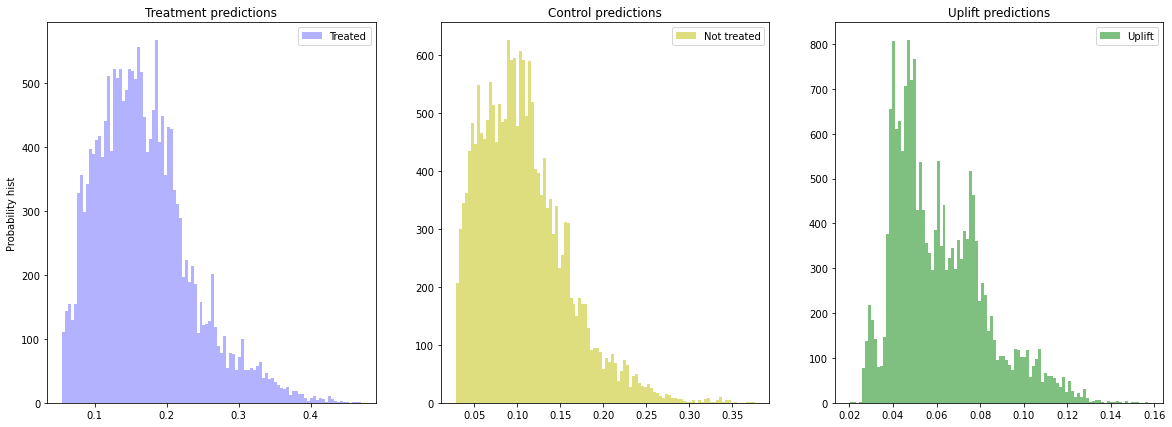

In [27]:
# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [28]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.570454
1,is_referral,18.176416
2,history,15.278555
3,recency,14.628784
4,used_bogo,12.966288
5,used_discount,7.548630
6,zip_code,7.148163
7,channel,4.682710


#### Трансформация классов

In [29]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

C:\Users\asavv\AppData\Local\Temp/ipykernel_28300/2830167889.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


In [34]:
ct_score_10

0.07844634268684902

In [35]:
ct_score_20

0.06889885707263119

#### Важность признаков

In [38]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,35.101339
1,used_bogo,16.995634
2,zip_code,11.483970
3,recency,10.907333
4,channel,10.852262
5,used_discount,8.404682
6,is_referral,6.254780


#### 2 модели

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

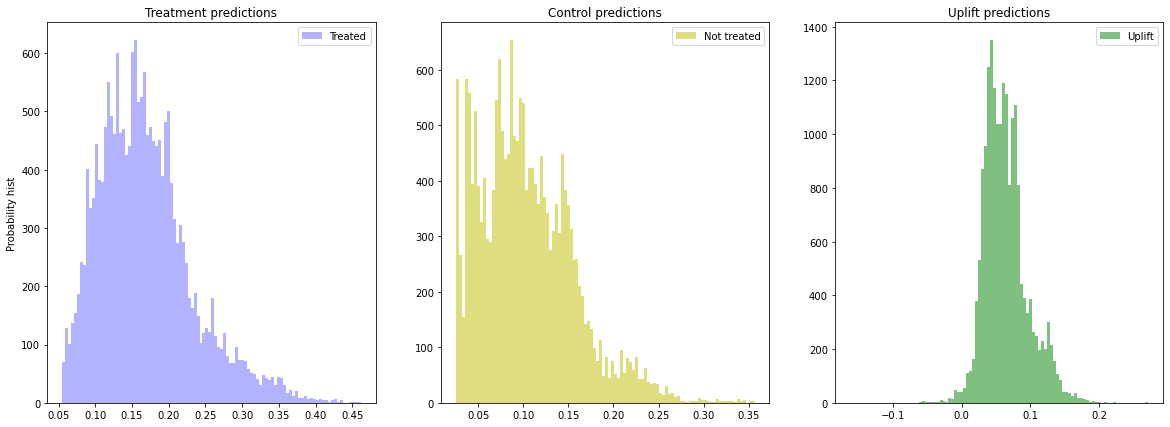

In [31]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    estimator_ctrl=CatBoostClassifier(n_estimators=600, max_depth=2, cat_features=cat_features, random_state=0, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [32]:
tm_score_10

0.08572211894996706

In [33]:
tm_score_20

0.08139977878825119

#### Важность признаков для первой модели

In [48]:
tm_fi_trmnt = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score': tm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_trmnt

,feature_name,feature_score
0,used_bogo,23.569915
1,is_referral,19.320389
2,history,18.809101
3,recency,14.625529
4,used_discount,11.917818
5,zip_code,7.626093
6,channel,4.131156


#### Важность признаков для контрольной группы

In [49]:
tm_fi_ctrl = pd.DataFrame({
    'feature_name': tm.estimator_ctrl.feature_names_,
    'feature_score': tm.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

tm_fi_ctrl

,feature_name,feature_score
0,is_referral,28.518056
1,recency,22.397461
2,history,19.490928
3,zip_code,14.432008
4,channel,6.283201
5,used_discount,4.587577
6,used_bogo,4.290768


**6.вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей**

In [50]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
2,TwoModels,0.085722,0.081400
1,ClassTransformation,0.078446,0.068899
0,SoloModel,0.071453,0.068669
